# Local approximation of an univariate quadratic expression using linear regression
 
### Learning goals:
- Mathematical statement of the linear regression using the simples data: univariate continuous function (single feature)
- Simple implementation using this closed form solution
- Definition of the usual metrics
- Move on to use existing libraries from Scipy or SKLearn to perform linear fitting and to perform an analysis of the model
- Increase the capacity of the model with powers of the features (polynomial)
- Understand iterative methods based on gradient descent, including the stochastic gradient descent

In [1]:
import math
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from sklearn import metrics as skMetrics
from sklearn.linear_model import LinearRegression as skLinearRegression 
import scipy as sy
import sympy
import pandas

## Generator Model

In [2]:
def generateBatch(N, stochastic = False):
    #
    xMin = 0
    xMax = 0.5
    #
    b = 0.35
    std = 0.01
    #
    if stochastic:
        x = random.uniform(xMin, xMax, N)
    else:
        x = np.linspace(xMin, xMax, N)
    yClean = x**4 + (x-0.3)**3 + b
    y =  yClean + random.normal(0, std, N) 
    return (x, y, yClean)

### Train data

In [3]:
xs = sympy.Symbol('x')
sympy.expand(xs**4 + (xs-0.3)**3 + 0.35)

x**4 + x**3 - 0.9*x**2 + 0.27*x + 0.323

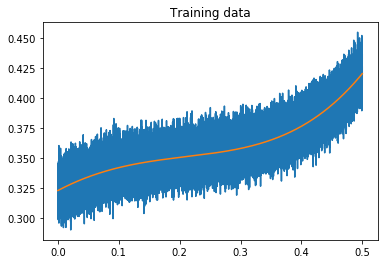

In [4]:
N = 100000
xTrain, yTrain, yClean = generateBatch(N)
plt.plot(xTrain, yTrain, xTrain, yClean);
plt.title('Training data');

### Test data

In [5]:
xTest, yTest, yTestClean = generateBatch(N)

# Closed form / analiticaly

Linear, 1st degree approximation of y:
\begin{align}
y = x w + b
\end{align}

Given $N_{feature} = 1$:

- $x$ is a $N_{sample}$ vector 
- $w$ is a scalar
- $y$ is a $N_{sample}$ vector
- $b$ is a scalar

Using mean square error (Euclidian norm), we are looking for $\hat{\theta} = \{\hat{b}, \hat{w}\}$ such that:

\begin{align}
\hat{\theta} \in {min}_{\theta} \lVert x w + b - y \rVert_2^2
\end{align}

\begin{align}
g(\theta) & = \lVert x w + b - y \rVert_2^2 \\
& = \sum_{i=0}^n \left(x_i^2 w^2 + y_i^2 + b^2 + 2x_iwb  - 2x_iwy_i - 2y_ib \right)\\
\end{align}

Lookup the minimum through the partial derivates:

\begin{cases}
\frac{\partial{g(\theta)}}{\partial b} = \sum_{i=0}^n 2(x_iw + b - y_i) \\
\frac{\partial{g(\theta)}}{\partial w} = \sum_{i=0}^n 2(x_iw + b - y_i)x_i 
\end{cases}

Let's define for any variable z:
\begin{align}
\overline{z_n} & = \frac 1n \sum_{i=0}^n z_i 
\end{align}

Then:
\begin{align}
& \begin{cases}
\frac{\partial{g(\theta)}}{\partial b} = 0 \\
\frac{\partial{g(\theta)}}{\partial w} = 0 
\end{cases}
\\ \iff &
\begin{cases}
\overline{x_n} w + b = \overline{y_n} & Eq1\\
\overline{x_n^2 }w + \overline{x_n} b = \overline{x_n y_n} & Eq2\\
\end{cases}
\end{align}

$Eq2 - Eq1 \overline{x_n}$ :

\begin{align}
& w \left( \overline{x_n^2} - \overline{x_n}^2 \right) = \overline{x_n y_n} - \overline{x_n}.\overline{y_n}\\
\end{align}

Leading to: 

\begin{align}
w &= \frac{\overline{x_n y_n} - \overline{x_n}.\overline{y_n}}{\overline{x_n^2} - \overline{x_n}^2}\\
  &= \frac{\sum_{i=0}^n \left(x_i - \overline{x_n} \right) \left(y_i - \overline{y_n} \right)}{\sum_{i=0}^n \left(x_i - \overline{x_n} \right)  } \\
b &= \sum_{i=0}^n y_i - x_i w = \overline{y} - \overline{x} w  \\
\end{align}

Remove biases

In [6]:
xUnB = xTrain - np.mean(xTrain)
yUnB = yTrain - np.mean(yTrain)

In [7]:
# In case x is univariate, the matrix product x^T x is a scalar
wEst = np.dot(xUnB, yUnB) / np.dot(xUnB, xUnB)
bEst = np.mean(yTrain - wEst * xTrain)
print('Linear regression estimate: y = {:.3f} x + {:.3f}'.format(wEst, bEst))

Linear regression estimate: y = 0.145 x + 0.323


### Test model

In [8]:
yEst1 = wEst * xTest + bEst

Closed form, MSE = 1.502e-04


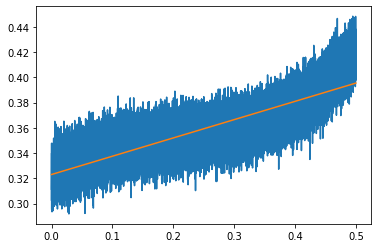

In [9]:
plt.plot(xTest, yTest, xTest, yEst1);
res = yTest - yEst1
mse1 = np.dot(res, res) / N
print('Closed form, MSE = {:.3e}'.format(mse1));

## Numpy polyfit, 1st degree
http://www.python-simple.com/python-numpy-scipy/fitting-regression.php

In [10]:
fit2 = np.polyfit(xTrain, yTrain, 1)
fit2

array([0.14488612, 0.32303991])

### Test model

In [11]:
yEst2 = fit2[0] * xTest + fit2[1]

Numpy polyfit 1st degree, MSE = 1.502e-04


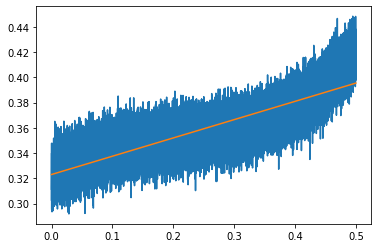

In [12]:
plt.plot(xTest, yTest, xTest, yEst2);
mse2 = skMetrics.mean_squared_error(yTest, yEst2)
print('Numpy polyfit 1st degree, MSE =', "{:.3e}".format(mse2));

## Numpy polyfit, 4th degree

In [13]:
fit3 = np.polyfit(xTrain, yTrain, 4)
fit3

array([ 1.03565332,  0.96438978, -0.88586569,  0.26726443,  0.3231845 ])

### Test model

In [14]:
yEst3 = xTest**4 * fit3[0] + xTest**3 * fit3[1] + xTest**2 * fit3[2] + xTest * fit3[3] + fit3[4]

Numpy polyfit 4th degre, MSE = 1.003e-04


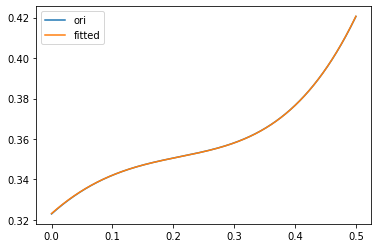

In [15]:
plt.plot(xTest, yTestClean, xTest, yEst3);
mse3 = skMetrics.mean_squared_error(yTest, yEst3)
plt.legend(['ori','fitted'])
print('Numpy polyfit 4th degre, MSE =', "{:.3e}".format(mse3));

## NumPy least square
http://www.python-simple.com/python-numpy-scipy/fitting-regression.php

In [16]:
fit4, residues, rank, s = np.linalg.lstsq(np.reshape(xUnB, (N,1)), yUnB)
fit4

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


array([0.14488612])

### Test model

In [17]:
yEst4 = fit4 * xTest + bEst

Numpy Least square, MSE = 1.502e-04


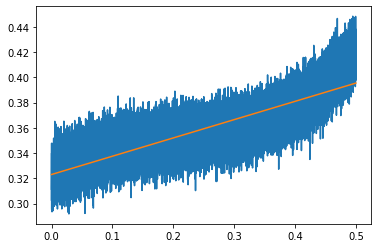

In [18]:
plt.plot(xTest, yTest, xTest, yEst4);
mse4 = skMetrics.mean_squared_error(yTest, yEst4)
print('Numpy Least square, MSE =', "{:.3e}".format(mse4));

## Scipy linear regression

http://www.python-simple.com/python-numpy-scipy/fitting-regression.php

In [19]:
fit5 = sy.stats.linregress(xTrain, yTrain)
fit5

LinregressResult(slope=0.14488612244983226, intercept=0.3230399081789981, rvalue=0.8633622269474659, pvalue=0.0, stderr=0.0002677762899562608)

### Test model

In [20]:
yEst5 = fit5.slope * xTest + fit5.intercept

Scipy, MSE = 1.502e-04


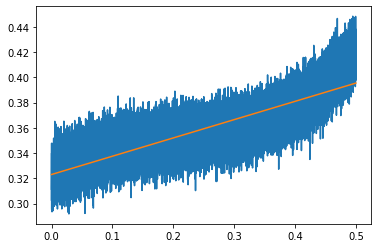

In [21]:
plt.plot(xTest, yTest, xTest, yEst5)
mse5 = skMetrics.mean_squared_error(yTest, yEst5)
print('Scipy, MSE =', "{:.3e}".format(mse5));

## SK Learn linear regression

In [22]:
model6 = skLinearRegression(normalize=False)
model6.fit(xTrain.reshape(-1,1), yTrain.reshape(-1,1))
print('SciKit Learn linear regression, b =', model6.intercept_[0], ', w =', model6.coef_[0][0])

SciKit Learn linear regression, b = 0.323039908178998 , w = 0.1448861224498326


In [23]:
print('SciKit Learn, R^2-score =', model6.score(xTest.reshape(-1,1), yTest))

SciKit Learn, R^2-score = 0.7448545267081639


### Test model

In [24]:
yEst6 = model6.predict(xTest.reshape(-1,1))

SciKit Learn, MSE = 1.502e-04


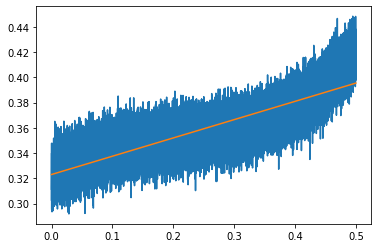

In [25]:
plt.plot(xTest, yTest, xTest, yEst6)
mse6 = skMetrics.mean_squared_error(yTest, yEst6)
print('SciKit Learn, MSE =', "{:.3e}".format(mse6));

# Gradient descent

Let's first plot MSE for several values of the slope in order to verify the convex shape of the cost function

In [26]:
Ns = 100
slope = np.linspace(-1, 1, Ns)
sx = np.matmul(np.reshape(xUnB, (N, 1)), np.reshape(slope,(1,Ns)))
er_sx_y = sx - np.reshape(yUnB, (N, 1)) 
mse = np.mean(er_sx_y.T**2, axis = 1)

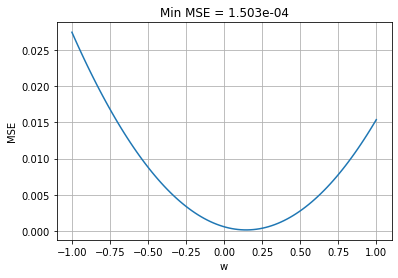

In [27]:
plt.plot(slope, mse)
plt.xlabel('w')
plt.ylabel('MSE')
plt.title('Min MSE = %.3e' % np.min(mse))
plt.grid();

Convexity of the MSE as function of the linear regression slope (w coefficient) is shown

### Gradient descent computation

In [28]:
def calcGradient(X, Y, b, w):
    A = w * X + b - Y
    F_db = np.sum(A)
    F_dw = np.dot(A, X)
    return (F_db, F_dw, math.sqrt(F_db**2 + F_dw**2))

In [29]:
# Initial coef
b7, w7 = 1, 1
threshold = 1e-1
learningRate = 1e-6
nIterMax = 1e5

# Init
gradient_b, gradient_w, gradientNorm = calcGradient(xTrain, yTrain, b7, w7)

print('START: b = %.3e' % b7, ', w = %.3e' % w7, ', Gradient norm = %.3e' % gradientNorm)
w7Learn = [np.array([b7, w7, gradientNorm])]

nIter = 0
while (gradientNorm > threshold) & (nIter < nIterMax):
    b7 = b7 - learningRate * gradient_b
    w7 = w7 - learningRate * gradient_w
    gradient_b, gradient_w, gradientNorm = calcGradient(xTrain, yTrain, b7, w7)
    w7Learn.append(np.array([b7, w7,  gradientNorm]))
    nIter += 1
    
print('END  : b = %.3e' % b7, ', w = %.3e' % w7, ', Gradient norm = %.3e' % gradientNorm, ', num iteration =', len(w7Learn))
df7 = pandas.DataFrame(w7Learn, columns = ('b', 'w', 'Gradient norm'))

START: b = 1.000e+00 , w = 1.000e+00 , Gradient norm = 9.226e+04
END  : b = 3.230e-01 , w = 1.449e-01 , Gradient norm = 9.981e-02 , num iteration = 4832


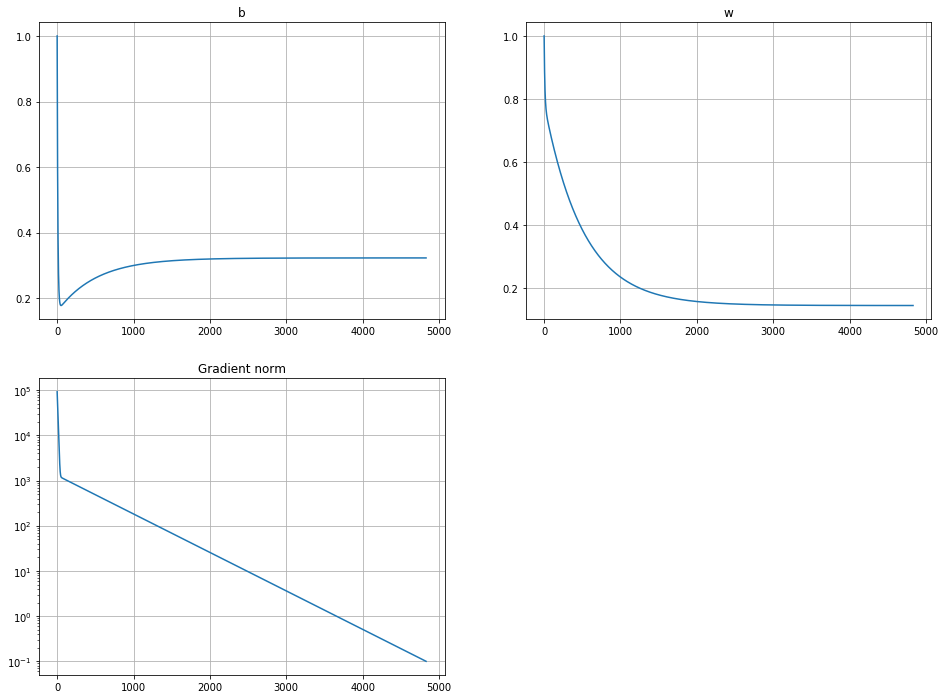

In [30]:
fig = plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plt.plot(df7['b'])
plt.grid()
plt.title('b');
plt.subplot(2,2,2)
plt.plot(df7['w'])
plt.grid()
plt.title('w');
plt.subplot(2,2,3)
plt.semilogy(df7['Gradient norm'])
plt.grid()
plt.title('Gradient norm');

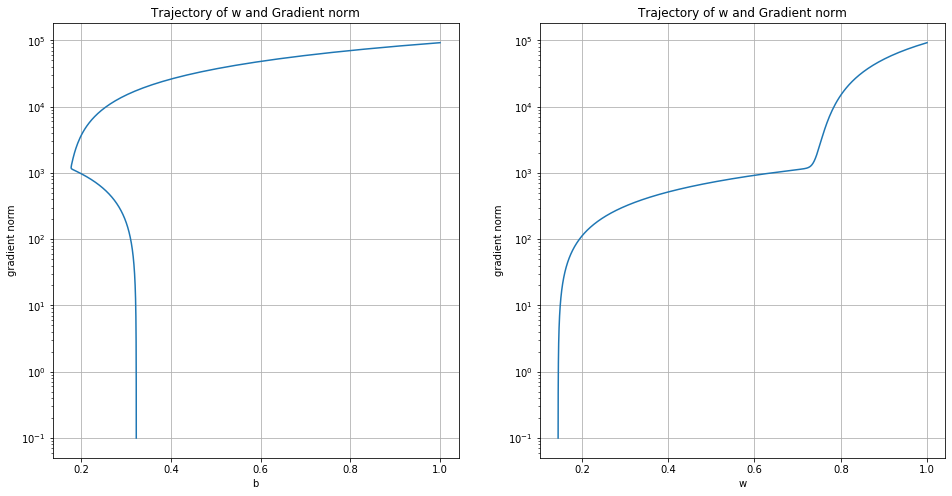

In [31]:
fig = plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.semilogy(df7['b'], df7['Gradient norm'])
plt.grid()
plt.xlabel('b')
plt.ylabel('gradient norm');
plt.title('Trajectory of w and Gradient norm');
plt.subplot(1,2,2)
plt.semilogy(df7['w'], df7['Gradient norm'])
plt.grid()
plt.xlabel('w')
plt.ylabel('gradient norm');
plt.title('Trajectory of w and Gradient norm');

### Test model

In [32]:
yEst7 = w7*xTest + b7

Gradient descent, MSE = 1.502e-04


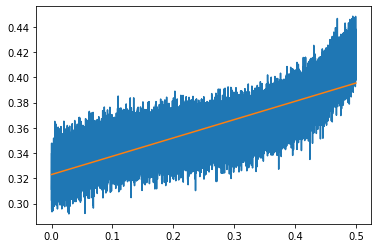

In [33]:
plt.plot(xTest, yTest, xTest, yEst7);
mse7 = skMetrics.mean_squared_error(yTest, yEst7)
print('Gradient descent, MSE =', '{:.3e}'.format(mse7));

## Stochastic gradient descent

Using new data batch at each iteration.

Alternatively, on a finite data set: shuffle the samples.

In [34]:
nBatch = 100
b8, w8 = 2, 2
threshold = 1e-3
learningRate = 1e-3
nIterMax = 1e5

# Initial batch
xBatch, yBatch, yBC = generateBatch(nBatch, True)
gradient_b, gradient_w, gradientNorm = calcGradient(xBatch, yBatch, b8, w8)

print('START: b = %.3e' % b8, ', w = %.3e' % w8, ', Gradient norm = %.3e' % gradientNorm)
w8Learn = [np.array([b8, w8, gradientNorm])]

# Continue
nIter = 0
while (gradientNorm > threshold) & (nIter < nIterMax):
    b8 = b8 - learningRate * gradient_b
    w8 = w8 - learningRate * gradient_w
    xBatch, yBatch, yBC = generateBatch(nBatch, True)
    gradient_b, gradient_w, gradientNorm = calcGradient(xBatch, yBatch, b8, w8)
    w8Learn.append(np.array([b8, w8,  gradientNorm]))
    learningRate = learningRate * 0.9999 # Decreasing learning rate
    nIter += 1
    
print('START: b = %.3e' % b8, ', w = %.3e' % w8, ', Gradient norm = %.3e' % gradientNorm, ', num iteration =', len(w8Learn))
df8 = pandas.DataFrame(w8Learn, columns = ('b', 'w', 'Gradient norm'))

START: b = 2.000e+00 , w = 2.000e+00 , Gradient norm = 2.230e+02
START: b = 3.219e-01 , w = 1.492e-01 , Gradient norm = 9.648e-04 , num iteration = 3495


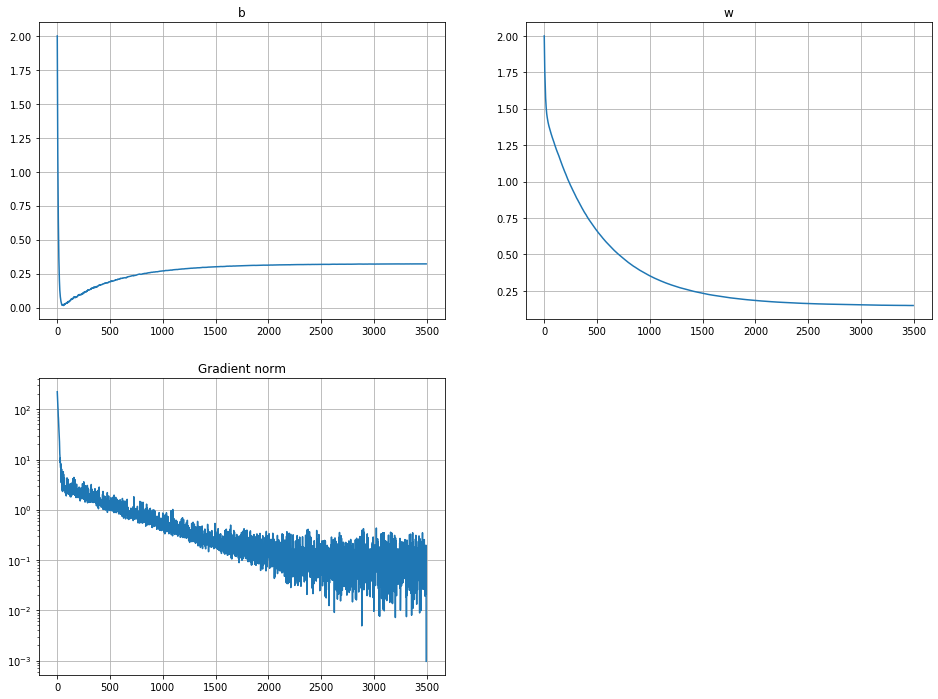

In [35]:
fig = plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plt.plot(df8['b'])
plt.grid()
plt.title('b');
plt.subplot(2,2,2)
plt.plot(df8['w'])
plt.grid()
plt.title('w');
plt.subplot(2,2,3)
plt.semilogy(df8['Gradient norm'])
plt.grid()
plt.title('Gradient norm');

The gradient norm is getting very noisy as the value is below $10^{-1}, a more adaptive learning rate would be needed there and a mean on the gradient norm to improve the stop condition of the gradient descent

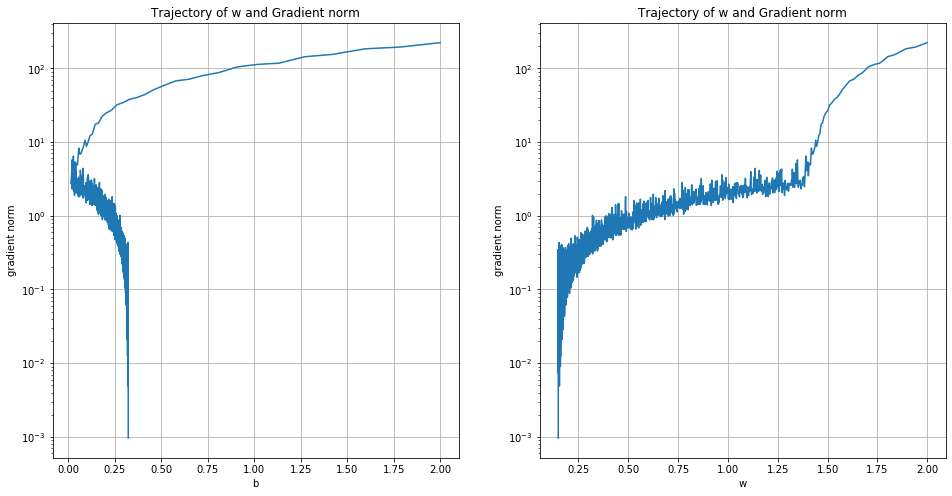

In [36]:
fig = plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.semilogy(df8['b'], df8['Gradient norm'])
plt.grid()
plt.xlabel('b')
plt.ylabel('gradient norm');
plt.title('Trajectory of w and Gradient norm');
plt.subplot(1,2,2)
plt.semilogy(df8['w'], df8['Gradient norm'])
plt.grid()
plt.xlabel('w')
plt.ylabel('gradient norm');
plt.title('Trajectory of w and Gradient norm');

### Test model

In [37]:
yEst8 = w8*xTest + b8

Stochastic gradient descent, MSE = 1.506e-04


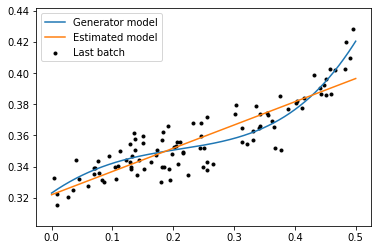

In [38]:
plt.scatter(xBatch, yBatch, marker='.', color = 'black');
plt.plot(xTrain, yClean)
plt.plot(xTest, yEst8)
plt.legend(['Generator model', 'Estimated model', 'Last batch'])
mse8 = skMetrics.mean_squared_error(yTest, yEst8) 
print('Stochastic gradient descent, MSE =', "{:.3e}".format(mse8));

## Gradient descent with SciKit Learn

https://scikit-learn.org/stable/modules/sgd.html#regression

In [39]:
from sklearn.linear_model import SGDRegressor as skSGDRegressor

model9 = skSGDRegressor(alpha=0.0001, average=False, 
           early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
           learning_rate='optimal', loss='squared_loss', max_iter=1000,
           n_iter_no_change=5, penalty='l2', power_t=0.5,
           random_state=None, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)
# l1_ratio=0.15,

Notes:
- Regularizer is called 'penalty' and parameterized by 'alpha' (and 'l1_ratio')
- Early stopping is available and parameterized by 'early_stopping', 'max_iter', 'tol' and 'n_iter_no_change'
- Shuffling between epochs enabled by 'shuffle'

In [40]:
model9.fit(xTrain.reshape(-1, 1), yTrain)
print('Y = {0} X + {1}'.format(model9.coef_, model9.intercept_))

Y = [0.14393348] X + [0.32146107]


In [41]:
yEst9 = model9.predict(xTest.reshape(-1,1))

Gradient descent with SK Learn, MSE = 1.536e-04


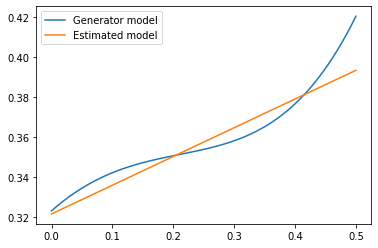

In [42]:
plt.plot(xTrain, yClean)
plt.plot(xTest, yEst9)
plt.legend(['Generator model', 'Estimated model'])
mse9 = skMetrics.mean_squared_error(yTest, yEst9) 
print('Gradient descent with SK Learn, MSE =', "{:.3e}".format(mse9));

# Main take-aways

Linear regression has a closed form leading to the best fit. Many Python libraries provide this linear or polynomial fitting.

We have also learnt gradient descent on this simple case, it will be very useful for coming projects based on neural networks.


# Where to go from here ?

__Other single feature linear implementation__ [using TensorFlow](LinearRegressionUnivariate-TensorFlow.html) ([Notebook](LinearRegressionUnivariate-TensorFlow.ipynb))

__More complex bivariate models__ [using "raw" Python](LinearRegressionBivariate.html) ([Notebook](LinearRegressionBivariate.ipynb)) up to the gradient descent with regularizer, or [using Keras](LinearRegressionBivariate-Keras.html) ([Notebook](LinearRegressionBivariate-Keras.ipynb))

__Compare with the single feature binary classification using logistic regression__ [using "raw" Python or libraries](../classification/ClassificationContinuousSingleFeature.html) ([Notebook](../classification/ClassificationContinuousSingleFeature.ipynb]))